# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%.
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%.
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=(10,180)),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

BATCH_SIZE = 64

# Create training set and define training dataloader
## YOUR CODE HERE ##
dataset_train = torchvision.datasets.CIFAR10(root="root", download=True, train=True, transform=transform )
dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train, shuffle=True, batch_size=BATCH_SIZE)

# Create test set and define test dataloader
## YOUR CODE HERE ##
dataset_test = torchvision.datasets.CIFAR10(root="root", download=True, train=False, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting root/cifar-10-python.tar.gz to root
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])

        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

In [4]:
# Explore data
## YOUR CODE HERE ##
img, lbl = next(iter(dataloader_train))
img[0].shape

torch.Size([3, 32, 32])

horse


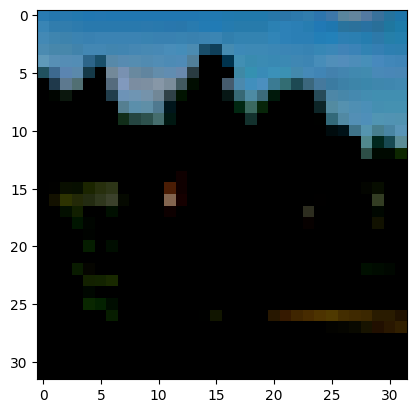

truck


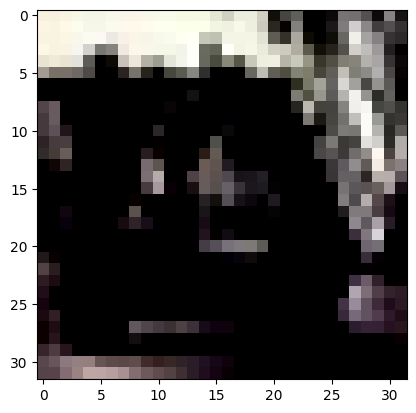

horse


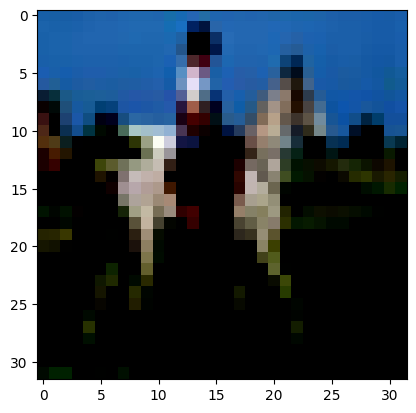

horse


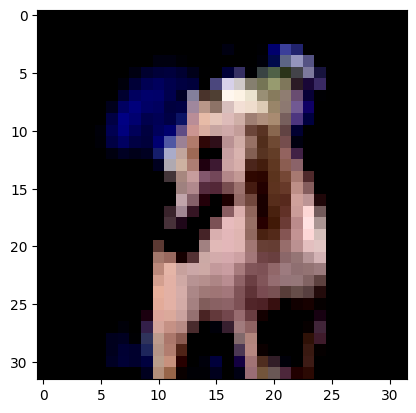

frog


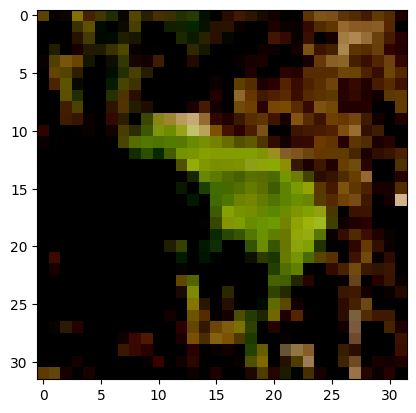

In [5]:
show5(dataloader_train)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [8]:
class model_cnn(nn.Module):

    def __init__(self):
        super().__init__()

#         Images Size = 224 x 224
#         O = output
#         W = Input Width
#         S = Stride
#         P = Padding
#         K = Kernel/Filter

#         O = (W-K + 2*P)/S + 1

        self.conv1 = nn.Conv2d( in_channels=3, out_channels=24,  kernel_size=3, stride =1, padding=2 )
        # O = (32-3 + 2*2)/1 + 1  = 34 ; O/2 = 17

        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride =1, padding=2)
        # O = (17-3 + 2*2)/1 + 1  = 19 ; O/2 = 9 (rounded down from to 9.5)

        self.conv3 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride =1, padding=2)
        # O = (9-3 + 2*2)/1 + 1  = 11 ; O/2 = 5 (rounded down from 5.5)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.batchNorm1 = nn.BatchNorm2d(24)
        self.batchNorm2 = nn.BatchNorm2d(48)
        self.batchNorm3 = nn.BatchNorm2d(96)

        self.fc1 = nn.Linear(96 * 5 * 5, 1024)
        self.drop1      = nn.Dropout(0.4)
        self.fc2        = nn.Linear(1024, 512)
        self.drop2      = nn.Dropout(0.3)
        self.fc3        = nn.Linear(512, 128)
        self.drop3      = nn.Dropout(0.3)
        self.fc4        = nn.Linear(128, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        x = self.maxpool(F.relu6(self.batchNorm1(self.conv1(x))))
        x = self.maxpool(F.relu6(self.batchNorm2(self.conv2(x))))
        x = self.maxpool(F.relu6(self.batchNorm3(self.conv3(x))))

        x = x.view(x.shape[0], -1)

        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))
        x = self.drop3(F.relu(self.fc3(x)))
        x = self.logsoftmax((self.fc4(x) ))


        return x


In [9]:
model_cnn()

model_cnn(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchNorm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2400, out_features=1024, bias=True)
  (drop1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (logsoft

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
## YOUR CODE HERE ##
model = model_cnn()

criterion = nn.NLLLoss()
# optimizer = optim.SGD( model.parameters(), lr= 0.01, )
optimizer = optim.Adam(  model.parameters(), lr= 0.005, )

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
## YOUR CODE HERE ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

model_cnn(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchNorm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2400, out_features=1024, bias=True)
  (drop1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (logsoft

In [12]:
print(device)

cuda


Plot the training loss (and validation loss/accuracy, if recorded).

In [13]:
training_loss = []
validation_loss = []
accuracy = []
prev_accuracy = 0


In [14]:
def train_model(epochs : int = 30, prev_accuracy : int =0):
    print(device)
    # epochs = 30
    print(prev_accuracy)

    print('training starting ...')
    for epoch in range(epochs):

        training_running_loss   = 0
        validation_running_loss = 0
        accuracy_running = 0

        if (accuracy_running > prev_accuracy):
            print('previous accuracy')

    #     print("epoch {} of {}".format(epoch+1, epochs))

        model.train()
        for idx, (images, labels) in enumerate(dataloader_train, start=1):


            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model.forward(images)
            loss   = criterion(output, labels  )

            loss.backward()
            optimizer.step()

            training_running_loss +=loss.item()


        model.eval()

        with torch.no_grad():

            validation_running_loss = 0

            for images, labels in dataloader_test:

                images = images.to(device)
                labels = labels.to(device)

                output = model.forward(images)
                loss = criterion(output, labels)

                prob = torch.exp(output)
                top_label, top_class = prob.topk(1, dim=1)

                equals = top_class == labels.view(*top_class.shape)

                accuracy_running += torch.mean(equals.type(torch.FloatTensor)).item()

                validation_running_loss += loss.item()

        validation_running_loss = validation_running_loss / len(dataloader_test)
        training_running_loss   = training_running_loss / len(dataloader_train)
        accuracy_running = accuracy_running / len(dataloader_test)

        training_loss.append(training_running_loss)
        validation_loss.append(validation_running_loss)
        accuracy.append(accuracy_running)

        save_prompt = ""
        if (accuracy_running > prev_accuracy):
            prev_accuracy = accuracy_running
            torch.save(model.state_dict(), 'best_model.pth')
            save_prompt = " best model saved"


        print("epoch {} of {}, training loss : {:.3f}, validation loss : {:.3f}, accuracy : {:.3f}, {}".format(epoch+1,
                                                                                               epochs,
                                                                                               training_running_loss,
                                                                                               validation_running_loss,
                                                                                               accuracy_running,
                                                                                               save_prompt
                                                                                              ))


    print('training completed')



In [15]:
train_model(30)

cuda
0
training starting ...
epoch 1 of 30, training loss : 1.892, validation loss : 1.572, accuracy : 0.394,  best model saved
epoch 2 of 30, training loss : 1.544, validation loss : 1.449, accuracy : 0.466,  best model saved
epoch 3 of 30, training loss : 1.396, validation loss : 1.243, accuracy : 0.556,  best model saved
epoch 4 of 30, training loss : 1.284, validation loss : 1.176, accuracy : 0.605,  best model saved
epoch 5 of 30, training loss : 1.202, validation loss : 1.149, accuracy : 0.603, 
epoch 6 of 30, training loss : 1.147, validation loss : 1.070, accuracy : 0.641,  best model saved
epoch 7 of 30, training loss : 1.098, validation loss : 1.031, accuracy : 0.643,  best model saved
epoch 8 of 30, training loss : 1.063, validation loss : 0.959, accuracy : 0.688,  best model saved
epoch 9 of 30, training loss : 1.030, validation loss : 0.935, accuracy : 0.688,  best model saved
epoch 10 of 30, training loss : 1.003, validation loss : 0.951, accuracy : 0.690,  best model sav

In [18]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 70%, great work!
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [20]:
## YOUR CODE HERE ##

def test_model():
  probs_list = []
  labels_list = []
  equal_list = []

  accuracy = 0
  model.eval()
  with torch.no_grad():
      for images, labels in dataloader_test:

          images = images.to(device)
          labels  = labels.to(device)

          output = model.forward(images)
          loss = criterion(output, labels)

          prob = torch.exp(output)
          top_label, top_class = prob.topk(1, dim=1)

          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

          equal_list.append(equals.squeeze().cpu().detach().numpy() )


  return probs_list, labels_list, equal_list, accuracy/len(dataloader_test)

probs, labels, equal_list, accuracy = test_model()
print(accuracy)

0.7596536624203821


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
## YOUR CODE HERE ##
checkpoint = {'input_size' : 3072,
              'hidden_size': [1024, 512, 256, 128],
              'output_size': 10,
              'state_dict' : model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature?
* What did you do to get the accuracy you achieved?
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



**Double click this cell to modify it**


My convolution neural network attained the accuracy of 75.96%, which is above the 70% threshold

Maxout Networks; Goodfellow et al., 2013 : The model introduced maxout activation function (maxout ounit) (https://arxiv.org/pdf/1302.4389)

In my CNN model, I made use of 3 convolutional layers, batch normalization, ReLU activation and a varying dropout rates from .40 to .30

my model still makes error in little over 24% of the times. Training for additional epochs, modifying the optimizer and the learning rate, increase sample size are few ways to help evaluate and improve the accuracy


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).